## Configurações de ambiente

In [1]:
# === Standard Library ===
import os
import copy
import pickle
import random

# === Third-party Libraries ===

# Data handling
import numpy as np
import pandas as pd

# Visualization
from great_tables import GT, md, html
import matplotlib.pyplot as plt
import seaborn as sns
import plotly

# Plotly high-resolution export settings (if needed)
plotly.io.renderers.default = "png"

# Set default font to Helvetica Neue in Plotly
plotly.io.templates["custom"] = plotly.io.templates["plotly_white"]
plotly.io.templates["custom"].layout.font.family = "Helvetica Neue"
plotly.io.templates.default = "custom"

# Matplotlib high-resolution settings
plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["font.family"] = "Helvetica Neue"

# Machine Learning & Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    roc_curve,
)

# Computer vision & augmentation
from PIL import Image
from torchvision import models, transforms

# Optimization
import optuna

# External integrations
import kagglehub

# === Project-specific Imports ===
from dataset import CatsDogsDataset, seed_worker
from neural_networks.simple_cnn import SimpleCNN
from neural_networks.tuning_simple_cnn import TuningSimpleCNN
from neural_networks.tuning_simple_cnn_bn import TuningSimpleCNNWithBN

/Users/vkz/mini_project_1/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [2]:
torch.set_num_threads(torch.get_num_threads())

In [3]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
device

device(type='mps')

In [4]:
# Set random seed for reproducibility
random.seed(42)
torch.manual_seed(42)

## Dados

In [5]:
path = kagglehub.dataset_download("ashfakyeafi/cat-dog-images-for-classification")
print("Path to dataset files:", path)

cat_dog_path = os.path.join(path, "cat_dog")

# Doing a stratified split to guarantee balanced datasets
df = pd.read_csv(os.path.join(path, "cat_dog.csv"))

train_df, temp_df = train_test_split(
    df, test_size=0.3, random_state=123, stratify=df["labels"]
)

val_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=123, stratify=temp_df["labels"]
)

transform = transforms.Compose(
    [
        transforms.Resize((150, 150)),
        transforms.ToTensor(),
    ]
)

# Creating datasets and applying transformations to the images
train_dataset = CatsDogsDataset(train_df, cat_dog_path, transform=transform)
val_dataset = CatsDogsDataset(val_df, cat_dog_path, transform=transform)
test_dataset = CatsDogsDataset(test_df, cat_dog_path, transform=transform)

# Creating dataloaders with 4 parallel workers to improve training speed
g = torch.Generator()
g.manual_seed(123)  # deterministic

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    generator=g,
)
val_loader = DataLoader(
    val_dataset, batch_size=32, num_workers=4, worker_init_fn=seed_worker, generator=g
)
test_loader = DataLoader(
    test_dataset, batch_size=32, num_workers=4, worker_init_fn=seed_worker, generator=g
)

Path to dataset files: /Users/vkz/.cache/kagglehub/datasets/ashfakyeafi/cat-dog-images-for-classification/versions/2


## Classes das arquiteturas

In [6]:
models_dict = {}

In [7]:
# Loading the saved model
model = SimpleCNN().to(device)
model_path = os.path.join("models", "cat_dog_model_v1.pt")
model.load_state_dict(torch.load(model_path))
model.eval()

models_dict["simple_cnn"] = model

In [8]:
# Loading the saved model
model = TuningSimpleCNN().to(device)
model_path = os.path.join("models", "optuna_best_model_final.pt")
model.load_state_dict(torch.load(model_path))
model.eval()

models_dict["tuning_simple_cnn"] = model

In [9]:
# Loading the saved model
model = TuningSimpleCNNWithBN().to(device)
model_path = os.path.join("models", "optuna_bn.pt")
model.load_state_dict(torch.load(model_path))
model.eval()

models_dict["tuning_simple_cnn_bn"] = model

In [10]:
model = models.resnet18(weights=None)
model.fc = nn.Sequential(nn.Linear(model.fc.in_features, 1), nn.Sigmoid())
model.load_state_dict(torch.load("models/resnet_transfer.pt"))
resnet_loaded = model.to(device)
resnet_loaded.eval()

models_dict["resnet"] = model

In [11]:
def get_random_samples(dataset, label, count=5):
    indices = [i for i, (_, y) in enumerate(dataset) if y == label]
    selected_indices = random.sample(indices, min(count, len(indices)))
    return [(dataset[i][0], dataset[i][1], i) for i in selected_indices]

In [ ]:
def predict_image(model, img_tensor, device):
    model.eval()
    with torch.no_grad():
        img_tensor = img_tensor.unsqueeze(0).to(device)
        output = model(img_tensor)
        if (
            isinstance(output, torch.Tensor) and output.size(1)
            if len(output.shape) > 1
            else 1 == 1
        ):
            confidence = output.item()
            predicted_class = 1 if confidence >= 0.5 else 0
        else:
            confidence, predicted_class = torch.max(output, 1)
            confidence = confidence.item()
            predicted_class = predicted_class.item()
    return predicted_class, confidence

In [ ]:
def visualize_predictions(model_dict, dataset, device):
    cat_samples = get_random_samples(dataset, 0, count=5)
    dog_samples = get_random_samples(dataset, 1, count=5)

    class_names = {0: "Cat", 1: "Dog"}

    for model_name, model in model_dict.items():
        plt.figure(figsize=(15, 10))
        plt.suptitle(f"Model: {model_name}", fontsize=16)

        all_samples = cat_samples + dog_samples

        for i, (img_tensor, true_label, idx) in enumerate(all_samples):
            pred_label, confidence = predict_image(model, img_tensor, device)

            img = img_tensor.permute(1, 2, 0).numpy()

            if img.max() <= 1.0:
                img = (img * 255).astype(np.uint8)

            plt.subplot(2, 5, i + 1)
            plt.imshow(img)

            color = "green" if pred_label == true_label else "red"

            title = f"True: {class_names[true_label]}\n"
            title += f"Pred: {class_names[pred_label]} ({confidence:.2f})"
            title += f"\n{':)' if pred_label == true_label else ':('}"

            plt.title(title, color=color)
            plt.axis("off")

        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()

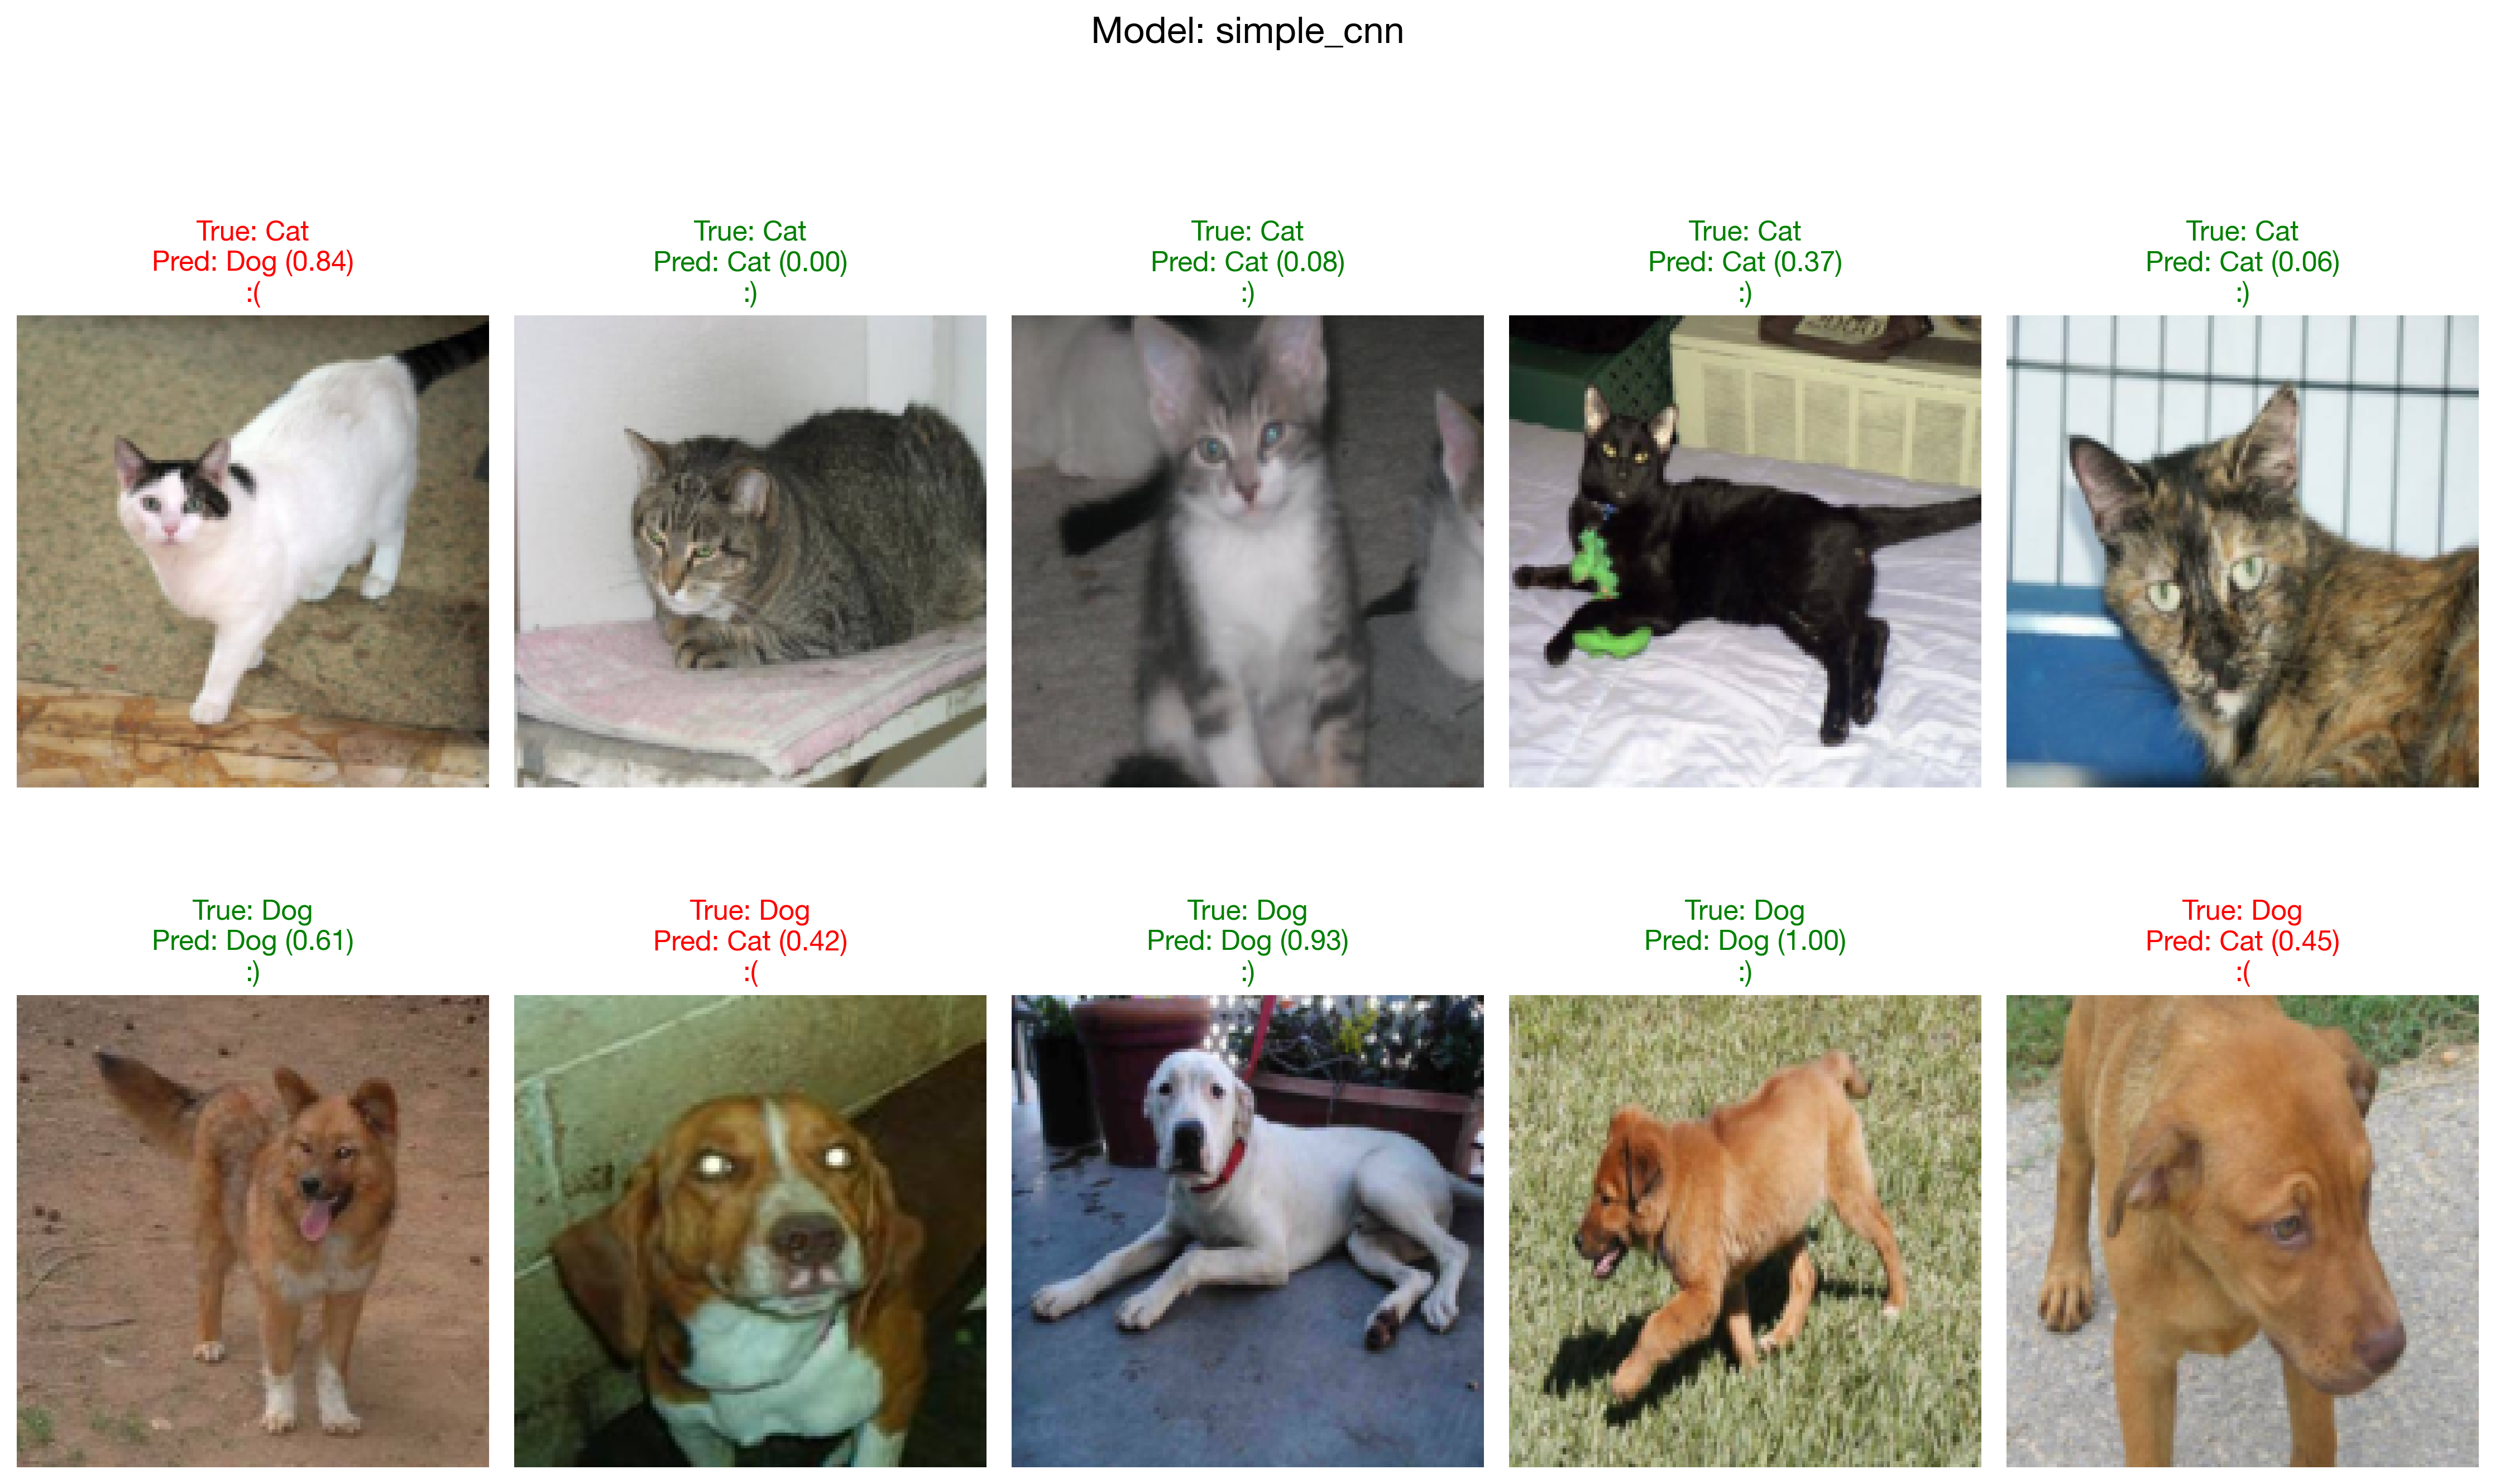

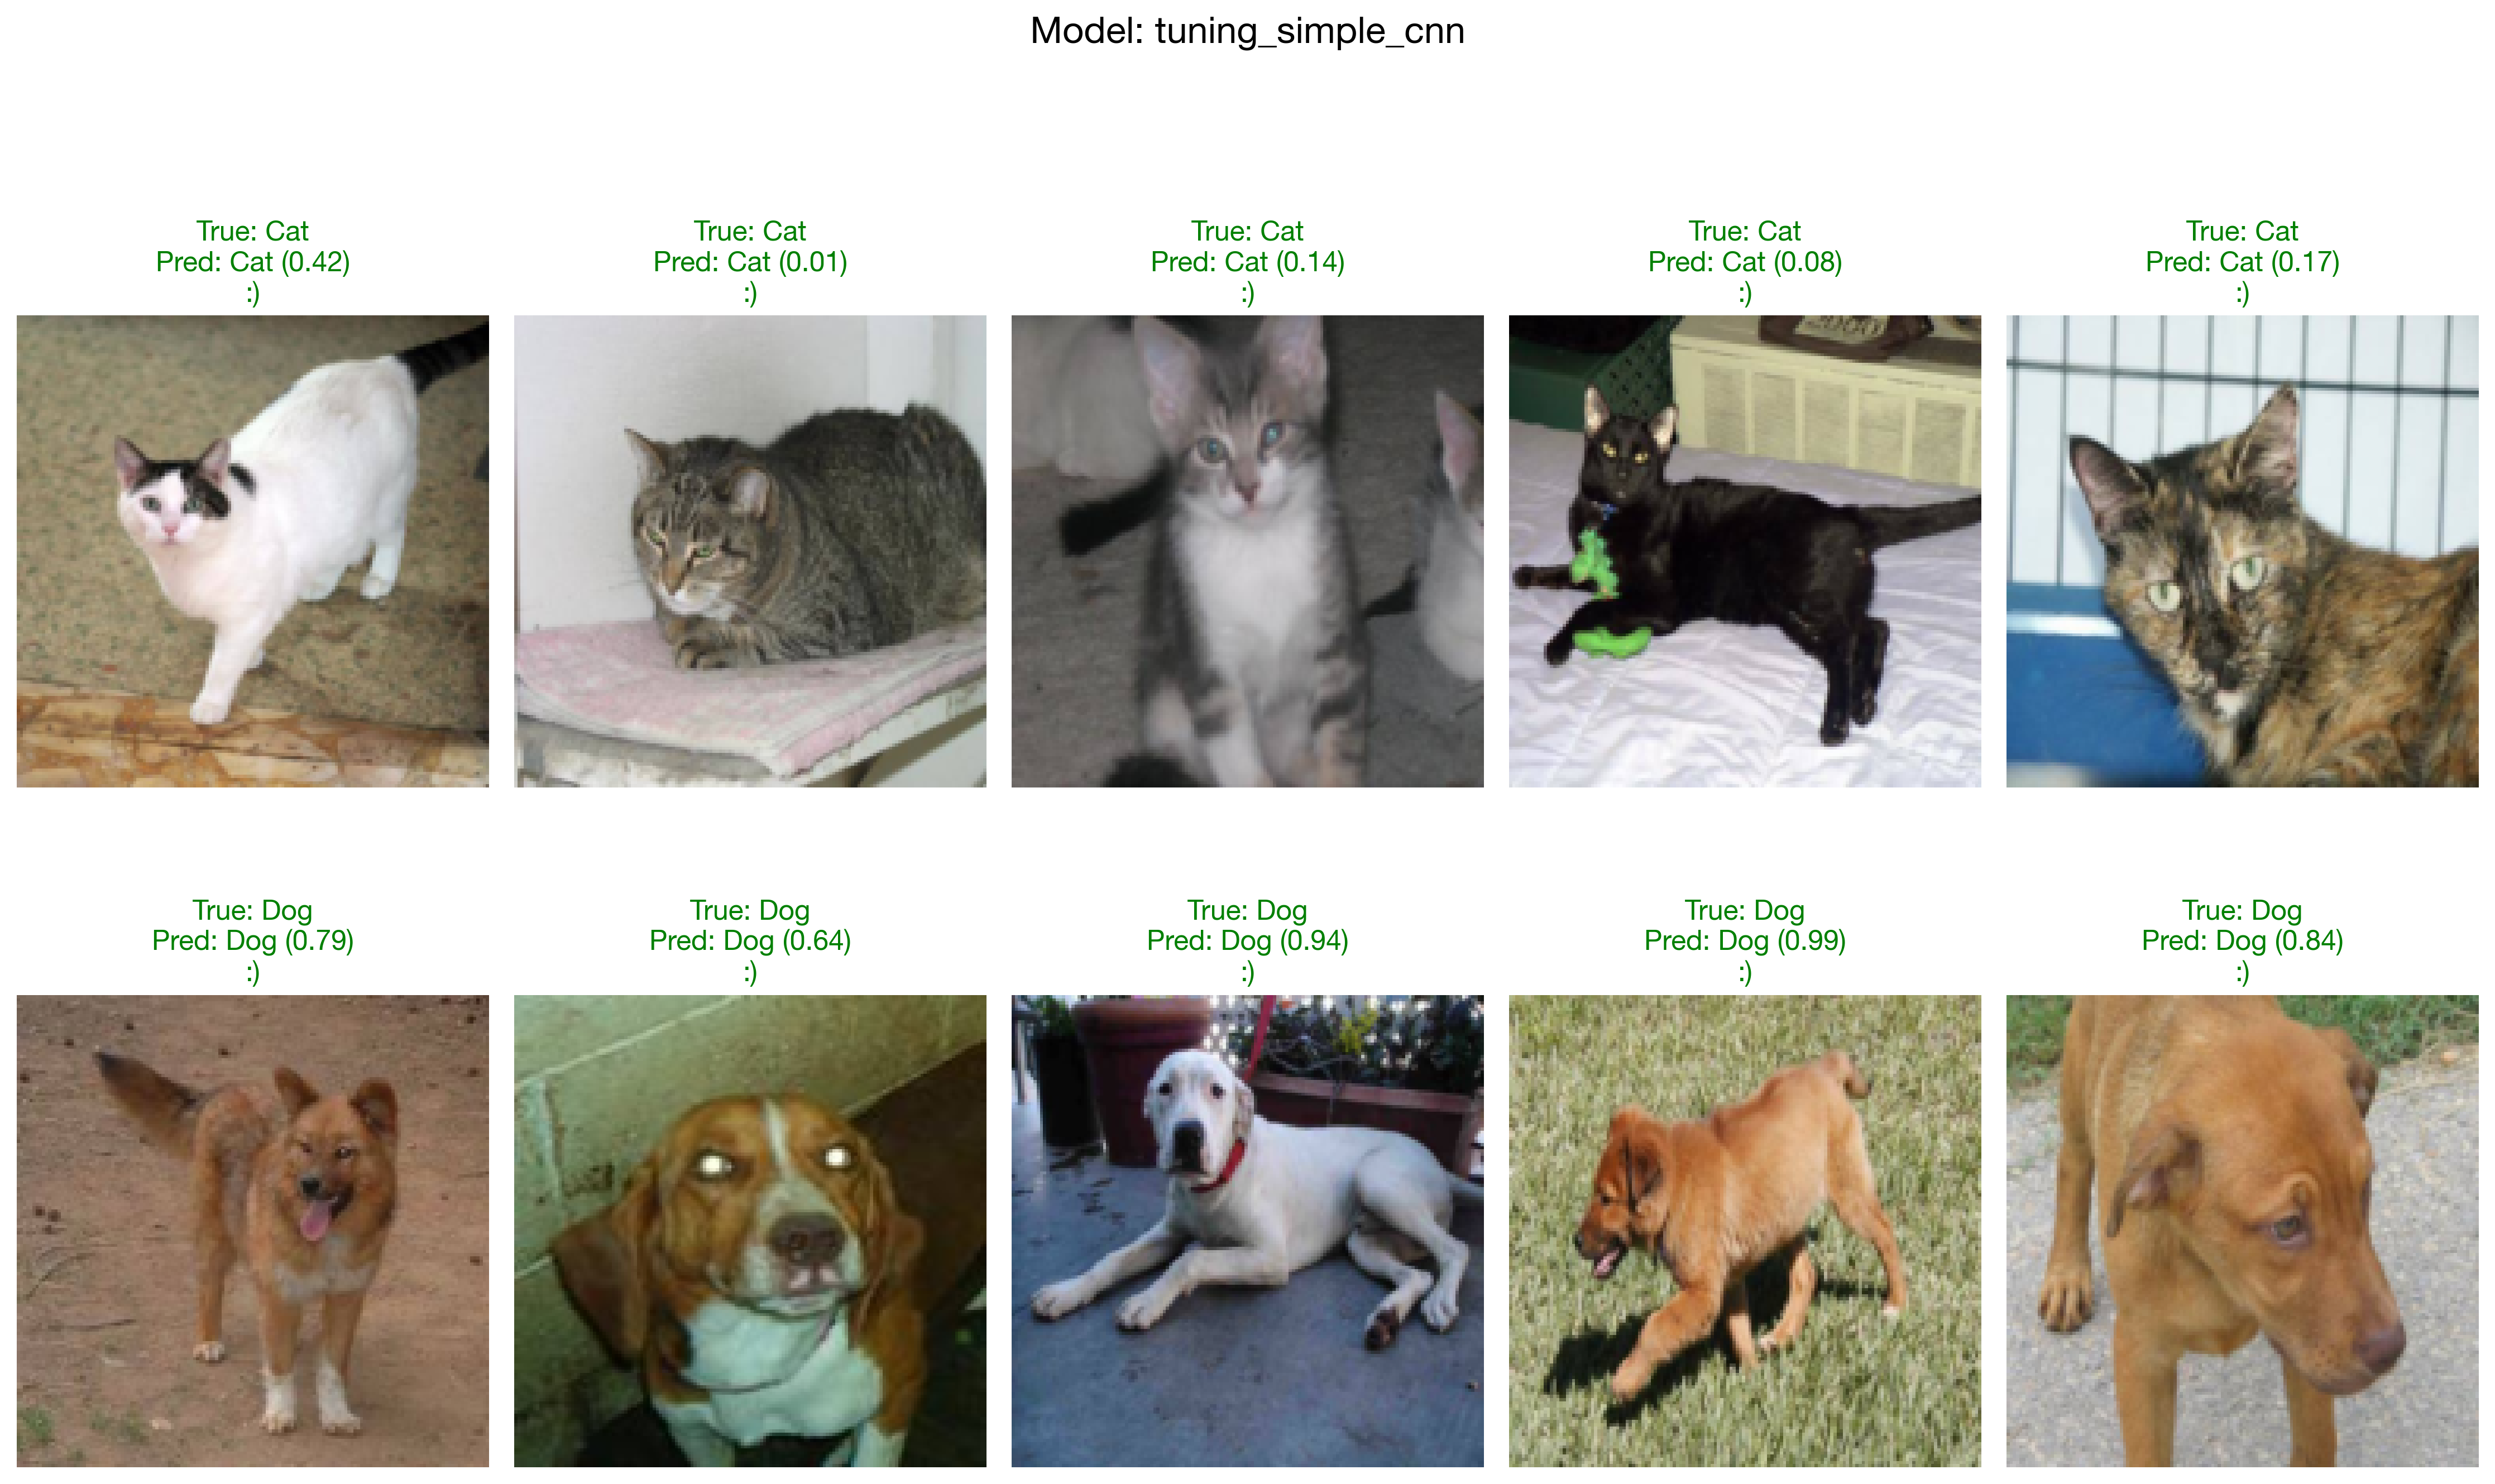

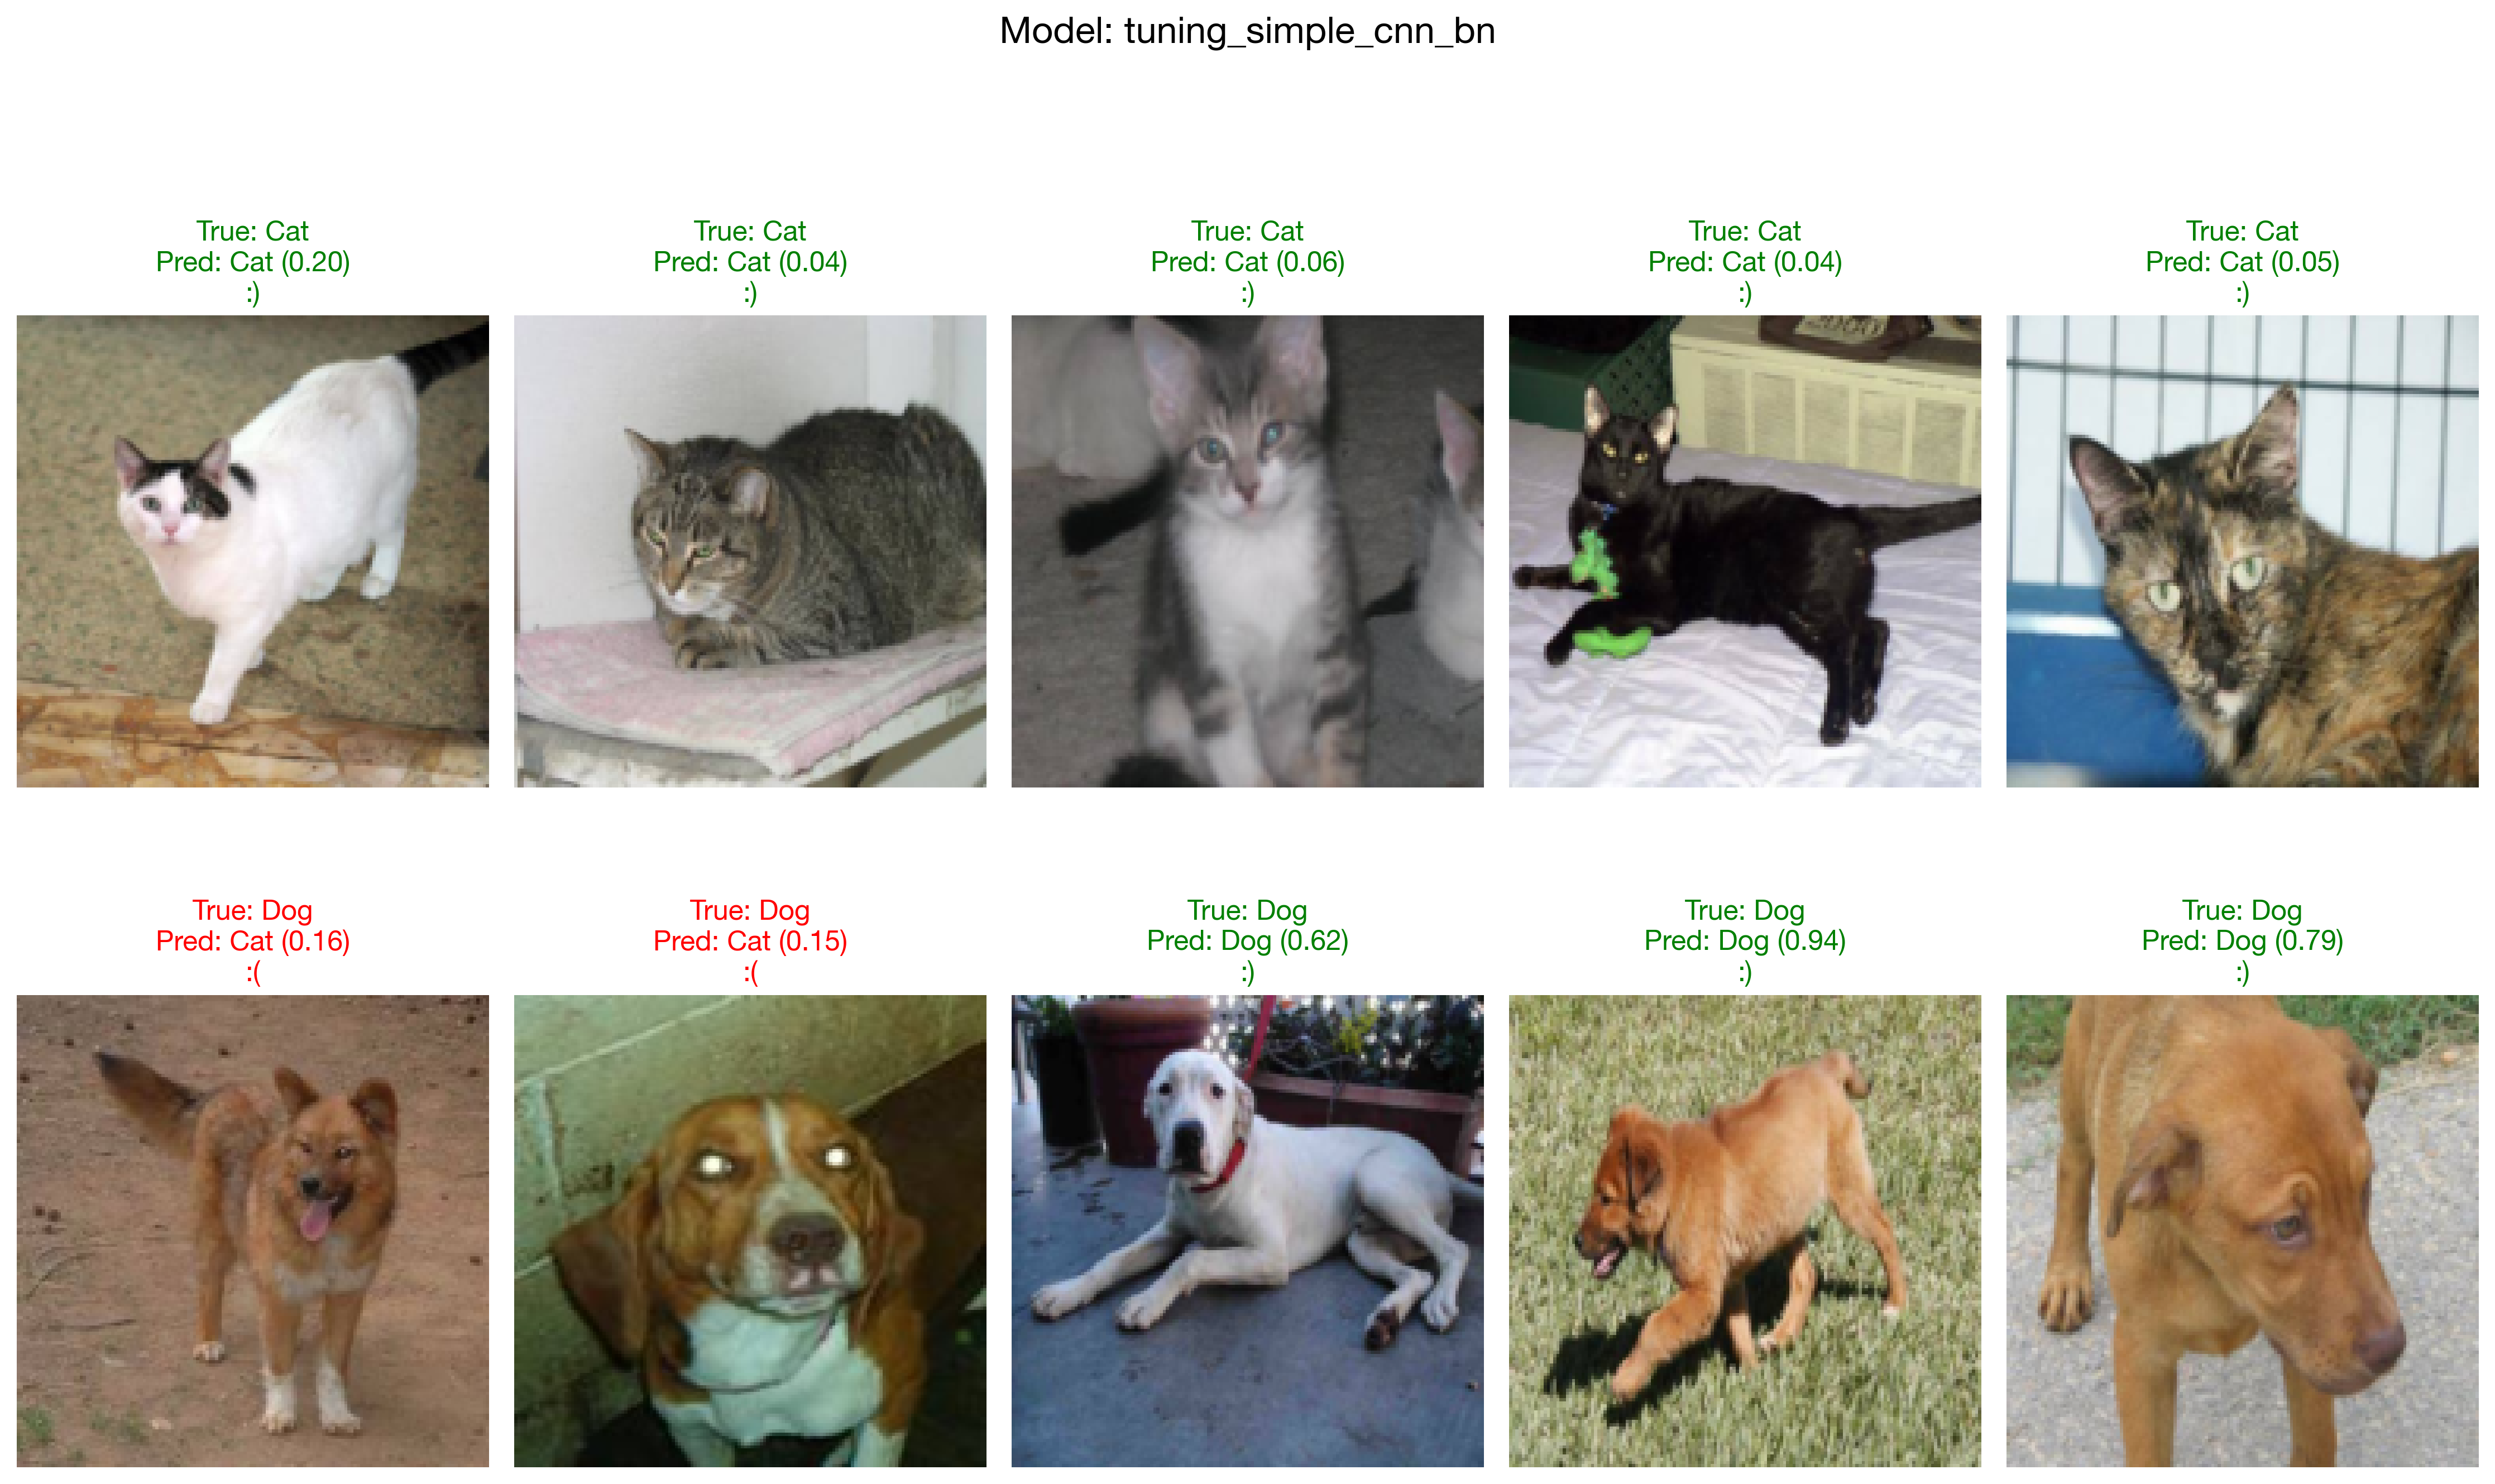

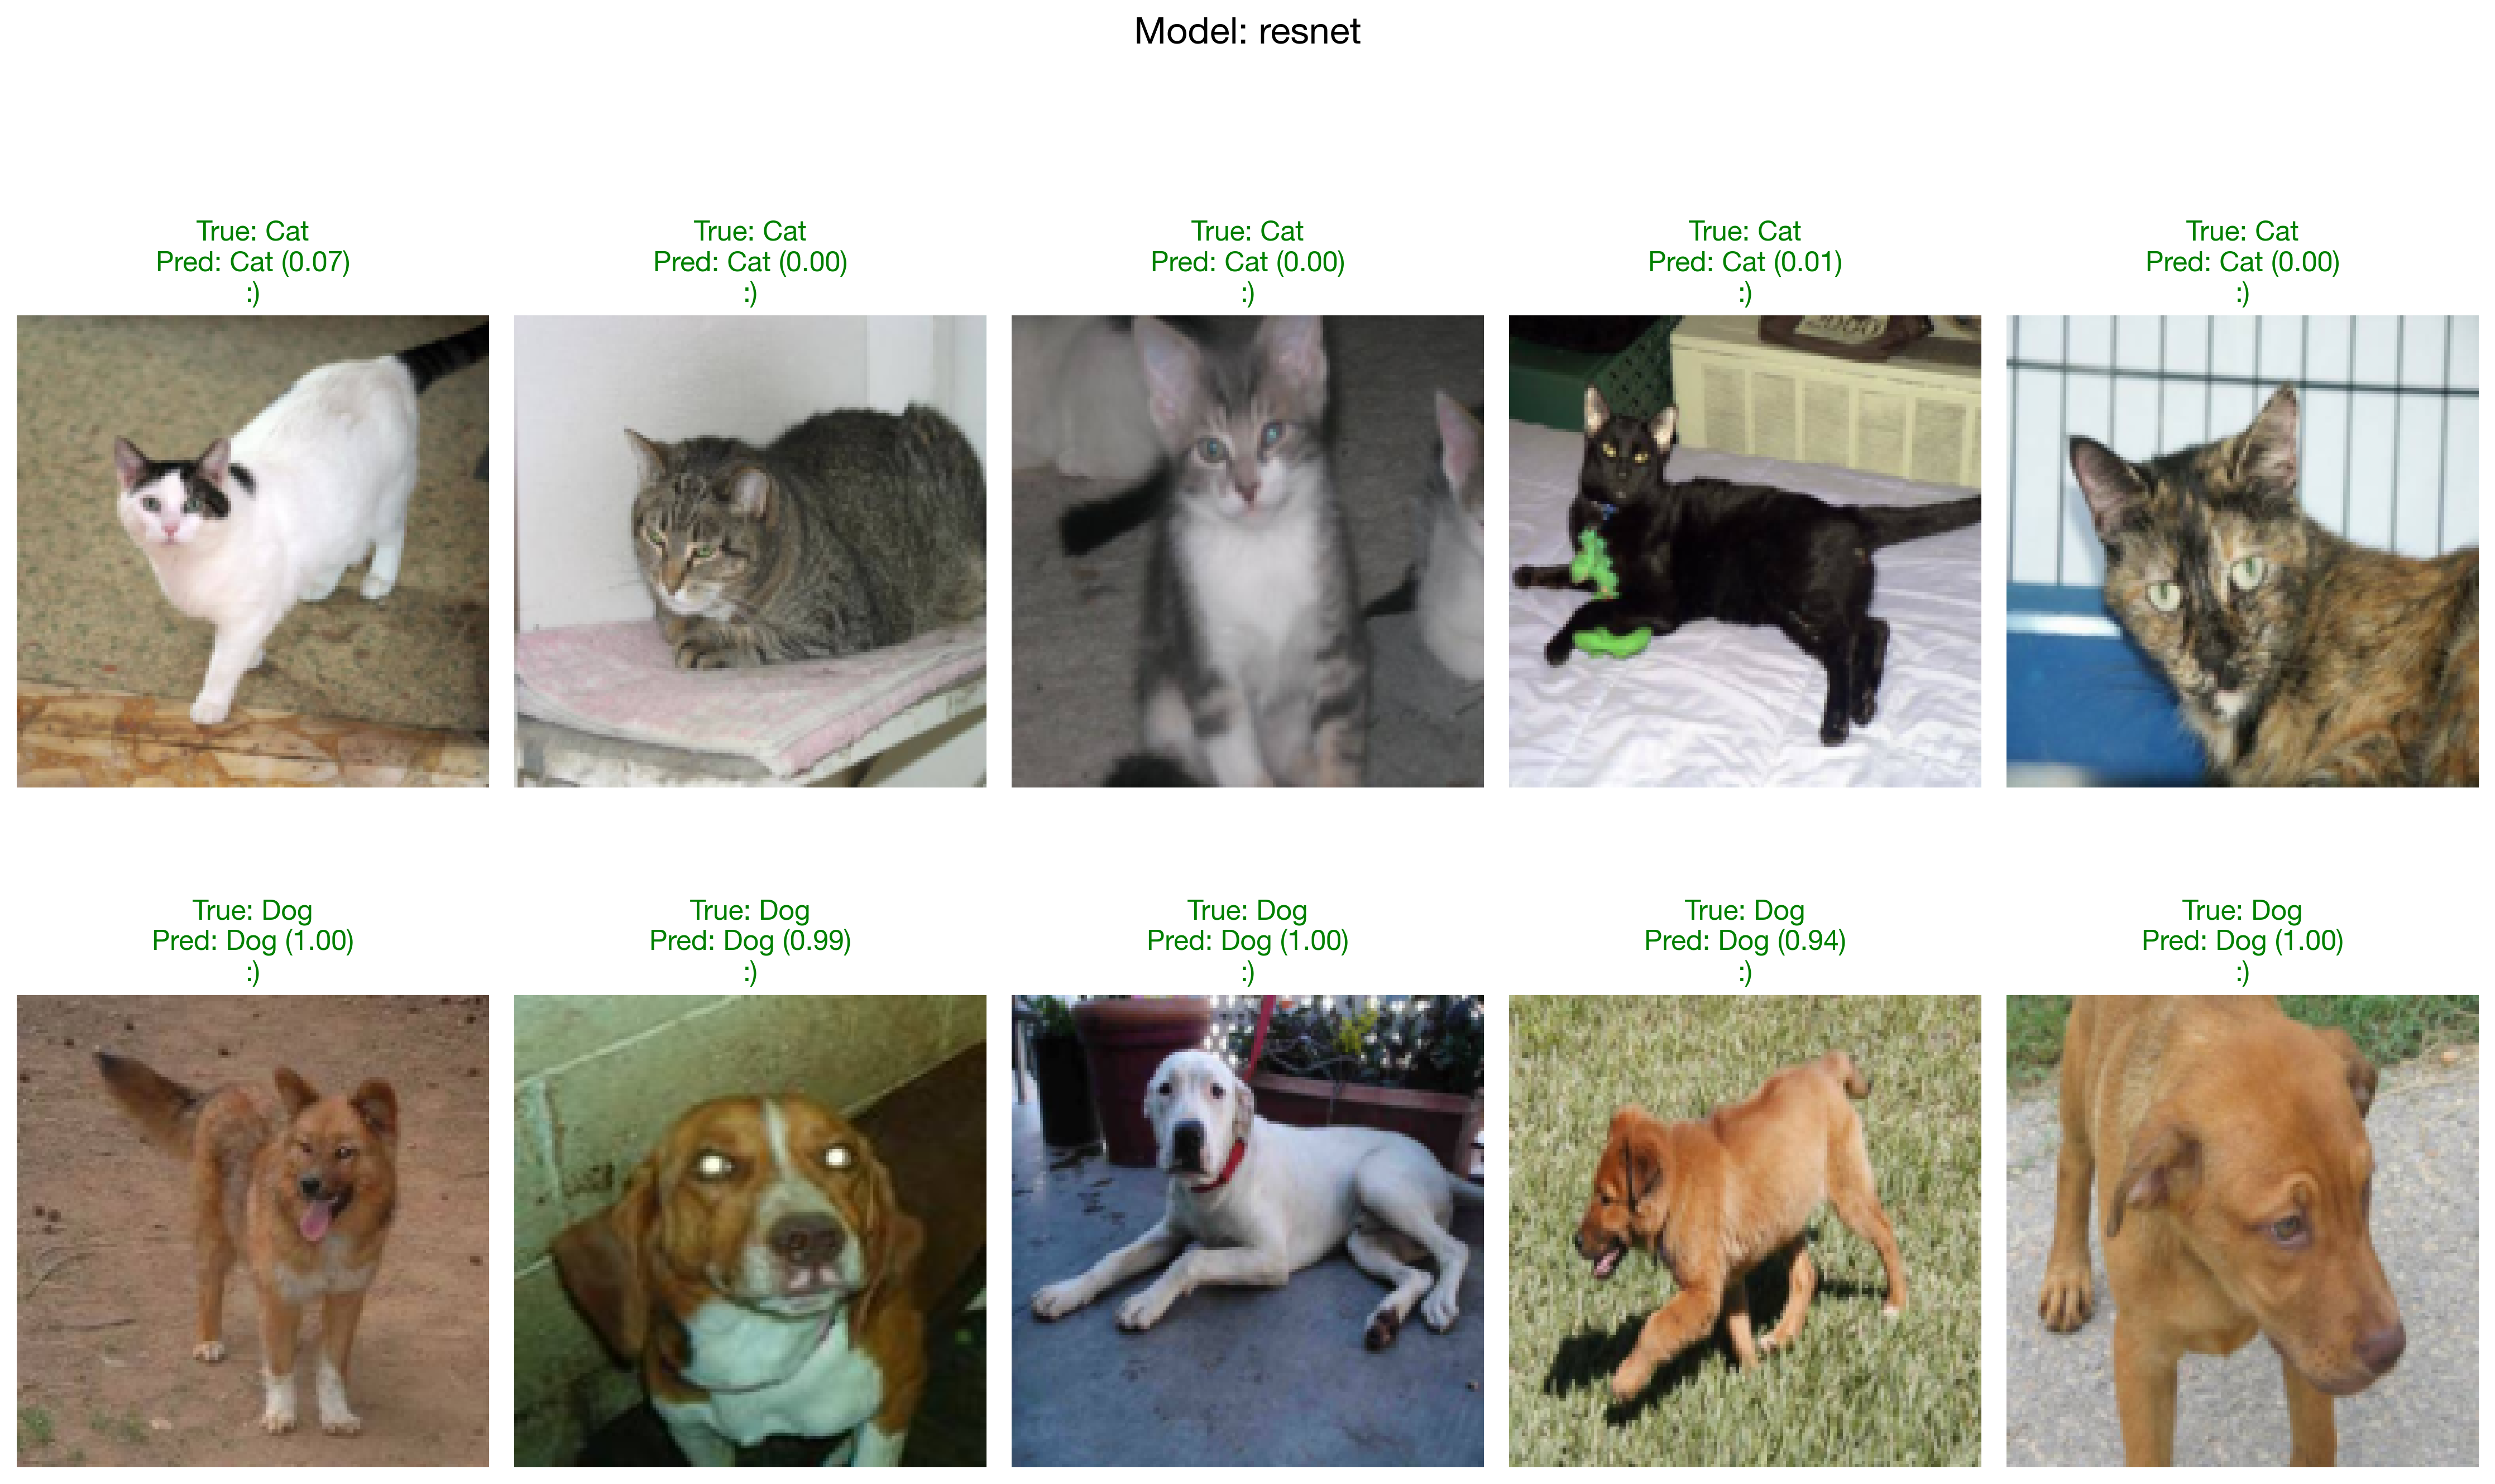

In [14]:
visualize_predictions(models_dict, test_dataset, device)